<a href="https://colab.research.google.com/github/dwjang0902/ExampleNew/blob/master/Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

요청 URL = http://finance.naver.com/item/sise_day.nhn?code= 049430
<class 'str'>
          date   close   diff    open    high     low   volume
13  2019.04.18  8030.0   30.0  8010.0  8050.0  7960.0   5157.0
12  2019.04.19  8020.0   10.0  8040.0  8100.0  7980.0  17340.0
11  2019.04.22  8190.0  170.0  8040.0  8220.0  8020.0  12740.0
10  2019.04.23  8180.0   10.0  8200.0  8230.0  8070.0  15379.0
9   2019.04.24  8150.0   30.0  8190.0  8240.0  8120.0   7029.0
5   2019.04.25  8100.0   50.0  8220.0  8220.0  8080.0   6811.0
4   2019.04.26  8060.0   40.0  8110.0  8170.0  7990.0   9073.0
3   2019.04.29  8100.0   40.0  8080.0  8150.0  8060.0   5958.0
2   2019.04.30  8110.0   10.0  8100.0  8180.0  8100.0   6024.0
1   2019.05.02  8150.0   40.0  8110.0  8180.0  8040.0   2427.0


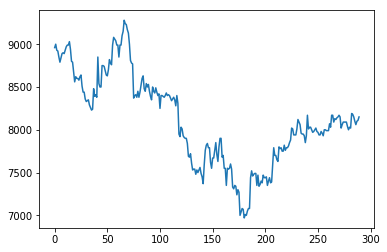

In [23]:
#---------------------------------------------------------
#주가 데이터 읽어오기
#---------------------------------------------------------
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph() # 중요한 부분이다; 이것이 없으면 런타임을 항상 리셋 해 주어야 한다.

#-------------------------------------------------------------------------------
# 한국거래소에서 종목코드 가져오기
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 
code_df.head()
#-------------------------------------------------------------------------------


# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
# 네이버 금융(http://finance.naver.com)에 넣어줌 
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
    
    print("요청 URL = {}".format(url)) 
    return url, code

# 신라젠의 일자데이터 url 가져오기 

item_name='코메론' 
url, code = get_url(item_name, code_df)
print(type(code))
# 왜 이렇게 해야 동작하는지 잘 모르겠다.
code = np.int(code)
code = str(code)
code = code.zfill(6)

code_num = code
#print(url)

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame()


# 1페이지에서 20페이지의 데이터만 가져오기 
for page in range(1, 30): 
#    pg_url = '{url}&page={page}'.format(url=url, page=page) # 동작을 않는다, 이유를 모르겠다 ???
    pg_url = 'http://finance.naver.com/item/sise_day.nhn?code=' + code_num + '&page='+ str(page)
#    print(pg_url)
#    df = pd.read_html(pg_url)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
 
# NaN 데이타 제거
df = df.dropna(axis = 0)

# 한글로 된 컬럼명을 영어로 바꿔줌 
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 

# 데이터의 타입을 int형으로 바꿔줌 
#df[['close', 'diff', 'open', 'high', 'low', 'volume']]  = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True) 

# 상위 5개 데이터 확인
print( df.tail(10))

plt.plot(df["close"].to_numpy())

#------------------------------------------------------------
# 예측하기 by RNN
#------------------------------------------------------------